In [9]:
# Install required packages (run only once if not already installed)
%pip install numpy==1.24.3 tensorflow==2.13.0 pandas scikit-learn matplotlib seaborn nltk wordcloud


  Using cached wordcloud-1.9.4-cp311-cp311-macosx_10_9_x86_64.whl.metadata (3.4 kB)
Using cached wordcloud-1.9.4-cp311-cp311-macosx_10_9_x86_64.whl (171 kB)
Note: you may need to restart the kernel to use updated packages.


In [34]:
# General-purpose libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# WordCloud visualisation
from wordcloud import WordCloud

# Machine Learning tools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.utils import class_weight

# Deep Learning tools
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# =============================
# SECTION 1 – Data Loading
# (Report: Dataset Description)
# =============================

# Load the dataset
df = pd.read_csv("disaster_tweets_dataset.csv")

# View basic information
print("Shape:", df.shape)
df.head()


Shape: (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# =============================
# SECTION 2 – Preprocessing
# (Report: Preprocessing Techniques)
# =============================

# NLTK setup
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Setup stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Cleaning function
def clean_text(text):
    if pd.isnull(text):
        return ''
    
    # Lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    
    # Remove mentions and hashtags
    text = re.sub(r'\@[\w]+|\#[\w]+', '', text)
    
    # Remove punctuation and special characters
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenisation + stopword removal + lemmatisation
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    return ' '.join(words)

# Remove duplicates and empty text
df.drop_duplicates(subset='text', inplace=True)
df.dropna(subset=['text'], inplace=True)

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)

# Remove any rows where cleaned text is now empty
df = df[df['clean_text'].str.strip() != '']

# Final check
df[['text', 'clean_text']].head()

print("Shape:", df.shape)

[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mac/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Shape: (7500, 6)


In [ ]:
# =============================
# SECTION 3 – Feature Extraction
# (Report: Feature Selection)
# =============================

# Initialise the TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Fit and transform the cleaned text into vectors
X = tfidf.fit_transform(df['clean_text'])

# Target variable (0 = not disaster, 1 = disaster)
y = df['target']

# Show shape of the result
print("TF-IDF matrix shape:", X.shape)

# Save final cleaned data (with original and clean_text columns)
df.to_csv("cleaned_disaster_tweets.csv", index=False)

print("Cleaned dataset saved as cleaned_disaster_tweets.csv")

TF-IDF matrix shape: (7500, 5000)
Cleaned dataset saved as cleaned_disaster_tweets.csv


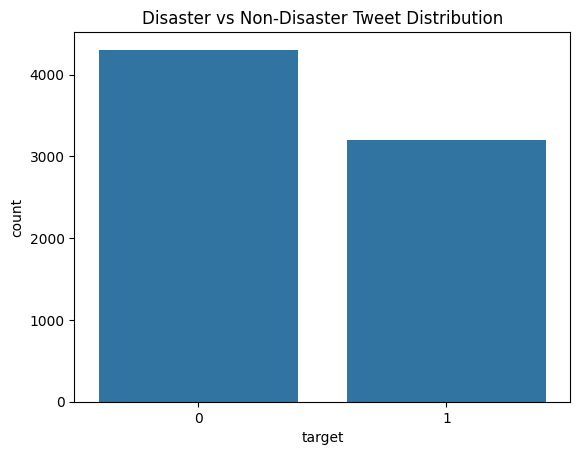

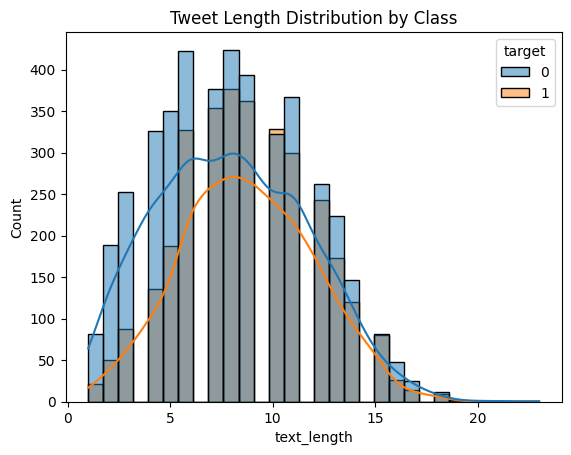

In [ ]:
# =============================
# SECTION 4 – Visualisation
# (Report: Data Visualisation)
# =============================

# Class distribution
sns.countplot(data=df, x='target')
plt.title('Disaster vs Non-Disaster Tweet Distribution')
plt.show()

# Word clouds
disaster_text = ' '.join(df[df['target'] == 1]['clean_text'])
non_disaster_text = ' '.join(df[df['target'] == 0]['clean_text'])

WordCloud(background_color='white').generate(disaster_text).to_image().show()
WordCloud(background_color='white').generate(non_disaster_text).to_image().show()

# Tweet length distribution
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))
sns.histplot(data=df, x='text_length', hue='target', bins=30, kde=True)
plt.title('Tweet Length Distribution by Class')
plt.show()

In [ ]:
# =============================
# SECTION 5 – Model Training (LR & SVM)
# (Report: Model Comparison)
# =============================

# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)

# Logistic Regression
lr = LogisticRegression(max_iter=200)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

# SVM
svm = SVC()
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)

# Evaluation
print("Logistic Regression:\n", classification_report(y_test, lr_preds))
print("SVM:\n", classification_report(y_test, svm_preds))

Training set: (6000, 5000)
Testing set: (1500, 5000)
Logistic Regression:
               precision    recall  f1-score   support

           0       0.78      0.91      0.84       868
           1       0.84      0.64      0.73       632

    accuracy                           0.80      1500
   macro avg       0.81      0.78      0.78      1500
weighted avg       0.80      0.80      0.79      1500

SVM:
               precision    recall  f1-score   support

           0       0.77      0.92      0.84       868
           1       0.85      0.62      0.72       632

    accuracy                           0.79      1500
   macro avg       0.81      0.77      0.78      1500
weighted avg       0.80      0.79      0.79      1500



Epoch 1/10
94/94 [==============================] - 6s 33ms/step - loss: 0.6145 - accuracy: 0.6633 - val_loss: 0.4634 - val_accuracy: 0.7980
Epoch 2/10
94/94 [==============================] - 2s 25ms/step - loss: 0.3489 - accuracy: 0.8563 - val_loss: 0.4745 - val_accuracy: 0.7800
Epoch 3/10
47/47 [==============================] - 1s 5ms/step
LSTM:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83       868
           1       0.79      0.72      0.75       632

    accuracy                           0.80      1500
   macro avg       0.80      0.79      0.79      1500
weighted avg       0.80      0.80      0.80      1500



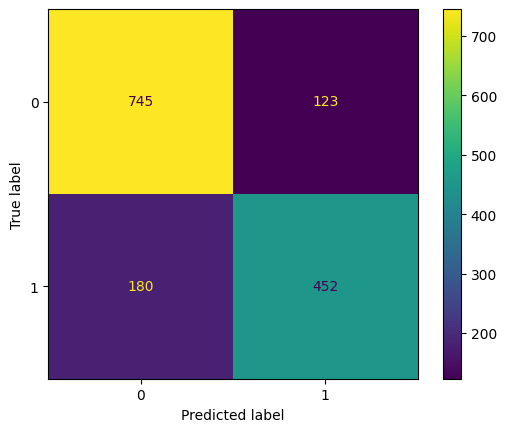

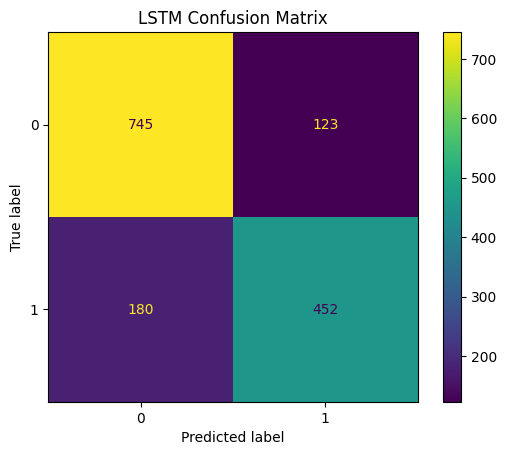

In [ ]:
# =============================
# SECTION 6 – LSTM Model
# (Report: Deep Learning Comparison)
# =============================

# Tokenise and pad
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])
seqs = tokenizer.texts_to_sequences(df['clean_text'])
X_seq = pad_sequences(seqs, maxlen=50, padding='post')
y_seq = df['target'].values

# Train-test split
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Class weights
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_seq), y=y_train_seq)
class_weights = {0: weights[0], 1: weights[1]}

# LSTM model with Bidirectional and EarlyStopping
model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=50),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.fit(X_train_seq, y_train_seq, epochs=10, validation_data=(X_test_seq, y_test_seq), batch_size=64, class_weight=class_weights, callbacks=[early_stop])

# Predict
lstm_preds = model.predict(X_test_seq)
lstm_preds = (lstm_preds > 0.5).astype("int32")

# Evaluation
print("LSTM:\n", classification_report(y_test_seq, lstm_preds))
ConfusionMatrixDisplay.from_predictions(y_test_seq, lstm_preds).plot()

plt.title("LSTM Confusion Matrix")
plt.show()